In [1]:
import numpy as np
import pickle as pkl
from Extractor import Extractor
from scipy.sparse import coo_matrix,csr_matrix
#import tensorflow as tf
import torch
from utils import *
import networkx as nx
from matplotlib import pyplot as plt
from model import *
from train import *

from explain import *
import time
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import to_networkx

import sys
%load_ext autoreload
%autoreload 2
np.set_printoptions(threshold=sys.maxsize)
dataset_name = 'syn3'

In [2]:
dataset_name = 'syn1'
with open('./dataset/' + dataset_name + '.pkl', 'rb') as fin:
    adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, edge_label_matrix  = pkl.load(fin)
hops = 3
allnodes = [i for i in range(511,871,6)]
all_label = np.logical_or(y_train,np.logical_or(y_val,y_test))
csr_adj = csr_matrix(adj)
extractor = Extractor(csr_adj,features,edge_label_matrix,all_label,hops)
sub_adj,sub_feature, sub_label,sub_edge_label_matrix = extractor.subgraph(allnodes[0])
single_label = np.argmax(all_label,axis=-1)
len([i for i in range(single_label.shape[0]) if single_label[i] ==1])

explainer


160

In [3]:
class BA_Shape_Dataset(Dataset):
    def __init__(self, root, name, setting = 1, hops=3, transform = None, pre_transform = None, subgraph = False, remap=False):
        super(BA_Shape_Dataset, self).__init__(root, transform, pre_transform)
        self.root = root
        self.subgraph = subgraph
        self.remap = remap
        self.name = name
        self.setting = setting
        with open(os.path.join(self.root, name + '.pkl'), 'rb') as fin:
            self.adj, self.features, self.y_train, self.y_val, self.y_test, self.train_mask, self.val_mask, self.test_mask, self.edge_label_matrix  = pkl.load(fin)
        self.hops = hops

        self.all_label = np.logical_or(self.y_train,np.logical_or(self.y_val,self.y_test))
        self.single_label = np.argmax(self.all_label,axis=-1)
        #self.allnodes = [i for i in range(self.single_label.shape[0]) if self.single_label[i] != 0] #[i for i in range(400,700,5)]
        self.csr_adj = csr_matrix(self.adj)
        self.extractor = Extractor(self.csr_adj,self.features,self.edge_label_matrix,self.all_label,self.hops)            
    @property
    def num_features(self):
        return 10
    @property
    def num_classes(self):
        return self.all_label.shape[1]

    @property 
    def allnodes(self):
        if self.setting==1:
            if self.name=='syn3':
                allnodes = [i for i in range(511,871,6)]
            elif self.name=='syn4':
                allnodes = [i for i in range(511,800,1)]
            else:
                allnodes = [i for i in range(400,700,5)] # setting from their original paper
        elif self.setting==2:
            allnodes = [i for i in range(self.single_label.shape[0]) if self.single_label[i] ==1]
        elif self.setting==3:
            if self.name == 'syn2':
                allnodes = [i for i in range(self.single_label.shape[0]) if self.single_label[i] != 0 and self.single_label[i] != 4]
            else:
                allnodes = [i for i in range(self.single_label.shape[0]) if self.single_label[i] != 0]
        return allnodes


    def get_subgraph(self, idx):
        #if self.subgraph:
        if True:
            idx = self.allnodes[idx] if self.remap else idx
            sub_adj,sub_feature, sub_label,sub_edge_label_matrix = dataset.extractor.subgraph(idx)
            return sub_adj,sub_feature, sub_label,sub_edge_label_matrix
        #else:
        #    return None
    def len(self):
        if self.subgraph:
            if not self.remap:
                return len(self.single_label)
            return len(self.allnodes)
        else:
            return 1
    
    def get(self, idx):
        if self.subgraph:
            if self.remap:
                idx = self.allnodes[idx]
            sub_adj,sub_feature, sub_label,sub_edge_label_matrix = self.extractor.subgraph(idx)
            edge_index = torch.tensor(preprocess_adj(sub_adj)[0].T, dtype = torch.long)
            x = torch.tensor(sub_feature).float()
            y = torch.argmax(torch.tensor(sub_label, dtype = torch.int32), dim=-1)
            data = Data(edge_index = edge_index, x = x, y = y)
        else:

            edge_index = torch.tensor(preprocess_adj(self.adj)[0].T, dtype = torch.long)
            x = torch.tensor(self.features).float()
            y = torch.argmax(torch.tensor(np.logical_or(self.y_train,np.logical_or(self.y_val,self.y_test)), dtype = torch.int32), dim=-1)
            data = Data(edge_index = edge_index, x = x, y = y)
        return data

In [4]:
dataset = BA_Shape_Dataset(root = './dataset', name = 'syn1', setting = 3)
dataset.allnodes

explainer


[300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 317,
 318,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 360,
 361,
 362,
 363,
 364,
 365,
 366,
 367,
 368,
 369,
 370,
 371,
 372,
 373,
 374,
 375,
 376,
 377,
 378,
 379,
 380,
 381,
 382,
 383,
 384,
 385,
 386,
 387,
 388,
 389,
 390,
 391,
 392,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 409,
 410,
 411,
 412,
 413,
 414,
 415,
 416,
 417,
 418,
 419,
 420,
 421,
 422,
 423,
 424,
 425,
 426,
 427,
 428,
 429,
 430,
 431,
 432,
 433,
 434,
 435,
 436,
 437,
 438,
 439,
 440,
 441,
 442,
 443,
 444,
 445,
 446,
 447,
 448,
 449,
 450,
 451,
 452,
 453,
 454,
 455,
 456,
 457,
 458,
 459,
 460,
 461,
 462,
 463,
 464,
 465,
 466

In [5]:
class GCN_Node(torch.nn.Module):
    def __init__(self, dataset, num_layers, hidden):
        super(GCN_Node, self).__init__()
        self.dataset = dataset
        self.conv1 = CD_GCNConv(dataset.num_features, hidden, normalize = True, add_self_loops = True)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(CD_GCNConv(hidden, hidden, normalize = True, add_self_loops = True))

        self.lin1 = CD_Linear(hidden, hidden)
        self.lin2 = CD_Linear(hidden, dataset.num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, data, CD_explain: bool = False, mask_index = None, Intermediate = False):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        if CD_explain:
            x = mask_x(x, mask_index)

        self.x0 = x
        self.edge_index = edge_index
        x = self.conv1(x, edge_index)
        self.x1 = x
        x = CD_relu(x)
        self.x2 = x
        self.x_convs = []
        for conv in self.convs:
            x = conv(x, edge_index)
            self.x_convs.append(x)
            x = CD_relu(x)
            self.x_convs.append(x)
        self.x3 = x
        #x = CD_global_max_pool(x, batch)
        x = self.lin1(x)
        self.x4 = x
        x = CD_relu(x)
        self.x5 = x
        #x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        self.x6 = x
        if CD_explain:
            self.x7 = x
            return x
        else:
            return F.log_softmax(x, dim=-1)

    def __repr__(self):
        return self.__class__.__name__

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [6]:
gcn_model = ATTGCN_Node(dataset, 3, 20)#GCN_Node(dataset, 3, 20)
#gcn_model = torch.load('./checkpoint/gcn_shape')
#gcn_model = torch.load('./checkpoint/model_temp')

In [7]:
dataset.setting = 3
dataset.subgraph = False
dataset.remap = True
node_pred_task_train(gcn_model, dataset, max_epoch=1000, lr=0.005, temp_name='shape_temp', train_rate = 0.8)

prepare dataloader
done
Epoch:  0 Avg loss:  1.3623929 ; acc:  0.24464285 ; epoch time:  1.1013782024383545
eval test...
test acc:  0.16428572
test loss:  1.3764504
saving...


Epoch:  1 Avg loss:  1.3507943 ; acc:  0.4232143 ; epoch time:  0.5771589279174805
eval test...
test acc:  0.45
test loss:  1.3637413
saving...


Epoch:  2 Avg loss:  1.3383737 ; acc:  0.4232143 ; epoch time:  0.5554227828979492
eval test...
test acc:  0.45
test loss:  1.3495679
saving...


Epoch:  3 Avg loss:  1.3245685 ; acc:  0.4232143 ; epoch time:  0.5656223297119141
eval test...
test acc:  0.45
test loss:  1.3338606
saving...


Epoch:  4 Avg loss:  1.310693 ; acc:  0.4232143 ; epoch time:  0.5759172439575195
eval test...
test acc:  0.45
test loss:  1.3181492
saving...


Epoch:  5 Avg loss:  1.2973483 ; acc:  0.4232143 ; epoch time:  0.5521869659423828
eval test...
test acc:  0.45
test loss:  1.3026968
saving...


Epoch:  6 Avg loss:  1.2857232 ; acc:  0.4232143 ; epoch time:  0.5544934272766113
eval test..

KeyboardInterrupt: 

In [8]:
gcn_model = torch.load('./checkpoint/shape_temp')

In [37]:
#torch.save(gcn_model, './checkpoint/gcn_shape')

In [40]:
gcn_model = torch.load('./checkpoint/gcn_shape')

In [7]:
dataset.setting=3
dataset.subgraph = False
dataset.remap= True
eval(gcn_model, dataset)

Epoch:  0 Avg loss:  0.31914735 ; acc:  0.91571426 ; epoch time:  0.2788865566253662


array(0.91571426, dtype=float32)

In [10]:
correct = 0
dataset.setting = 3
dataset.subgraph = True
dataset.remap = False
#load_model = torch.load('./checkpoint/gcn_mix').to('cuda')
load_model = gcn_model
load_model.eval()
in_correct = []
for idx in range(dataset.len()):
    print('index: ', idx)
    data = get_data(dataset, idx).to('cuda')
    pred = load_model.forward(data)
    print(pred)
    #print(preds)
    label = data.y.to('cuda')

    _, indices = torch.max(pred, 1)
    #print(pred)
    #print(label)
    #print(torch.sum(label))
    #print(indices)
    #print(torch.argmax(load_model(data)[0]))
    if (indices[0] == label[0]):
        correct += 1
    else:
        in_correct.append(idx)
        print(in_correct)
print(correct)


index:  0
tensor([[-1.0967e-05, -1.1416e+01, -3.9424e+01, -8.1025e+01],
        [ 0.0000e+00, -2.8830e+01, -9.8551e+01, -2.0132e+02],
        [-5.5669e-05, -9.7968e+00, -3.3847e+01, -6.9563e+01],
        ...,
        [-1.2697e+00, -1.1054e+00, -1.3266e+00, -2.0986e+00],
        [-1.0817e+00, -1.0247e+00, -1.4846e+00, -2.5839e+00],
        [-1.1522e+00, -1.0519e+00, -1.4160e+00, -2.3849e+00]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
index:  1
tensor([[ 0.0000e+00, -2.9077e+01, -9.9374e+01, -2.0298e+02],
        [-1.1563e-05, -1.1364e+01, -3.9242e+01, -8.0643e+01],
        [-5.3881e-05, -9.8282e+00, -3.3953e+01, -6.9780e+01],
        ...,
        [-1.6549e+00, -1.3250e+00, -1.1806e+00, -1.4439e+00],
        [-1.1522e+00, -1.0519e+00, -1.4160e+00, -2.3849e+00],
        [-1.2307e+00, -1.0887e+00, -1.3542e+00, -2.1793e+00]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
index:  2
tensor([[-5.1974e-05, -9.8641e+00, -3.4075e+01, -7.0030e+01],
        [-1.2398e-05, -1.130

KeyboardInterrupt: 

In [20]:
pred.shape

torch.Size([355, 4])

In [10]:

load_model = gcn_model.to('cuda')
correct = 0
dataset.setting = 3
dataset.subgraph = False
dataset.remap = False
data = get_data(dataset, 0).to('cuda')
pred = load_model.forward(data)
label = data.y.to('cuda')
_, indices = torch.max(pred, 1)

In [11]:
torch.where(indices != label)

(tensor([301, 304, 306, 309, 310, 313, 314, 315, 318, 319, 321, 324, 329, 334,
         336, 339, 341, 344, 346, 349, 351, 354, 356, 357, 359, 361, 364, 366,
         369, 371, 374, 376, 379, 381, 384, 386, 389, 391, 392, 393, 394, 396,
         399, 401, 404, 406, 409, 411, 414, 416, 419, 421, 424, 426, 429, 431,
         434, 436, 439, 441, 444, 446, 449, 451, 454, 456, 459, 461, 464, 466,
         468, 469, 471, 474, 476, 479, 481, 484, 486, 489, 491, 494, 496, 499,
         501, 504, 506, 509, 511, 514, 516, 519, 521, 524, 526, 529, 531, 534,
         536, 539, 541, 544, 546, 549, 551, 554, 556, 559, 561, 564, 566, 569,
         571, 574, 576, 579, 581, 584, 586, 589, 591, 594, 596, 599, 601, 604,
         606, 609, 611, 614, 616, 619, 621, 624, 626, 629, 631, 634, 636, 639,
         641, 644, 646, 649, 651, 653, 654, 656, 659, 661, 664, 666, 669, 671,
         674, 676, 679, 681, 684, 686, 689, 691, 694, 696, 699],
        device='cuda:0'),)

In [53]:
acc_list = []
auc_list = []
node_num_list = []
dataset.subgraph = True
dataset.remap = True
dataset.setting=1
load_model = gcn_model
#load_model = torch.load('./checkpoint/gcn_mix').to('cuda')
load_model.eval()

all_node_label = []
all_node_color = []
for idx in range(dataset.len()):
#for idx in range(20):
    #if idx in in_correct:
    #    continue
    print('\nindex: ', idx)
    sub_adj,sub_feature, sub_label,sub_edge_label_matrix = dataset.get_subgraph(idx)
    #truth_node = np.where(sub_label[:,1] == True)[0]
    truth_node = get_node_set(sub_edge_label_matrix)
    #if len(truth_node) > 6:
    #    continue
    print('0 label: ', np.argmax(sub_label[0],axis=-1))
    node_sort, node_color = print_explain(dataset, load_model, idx, class_idx = np.argmax(sub_label[0],axis=-1), visible = False)
    print(node_color)
    node_label = np.array([0] * sub_label.shape[0])
    node_label[list(truth_node)] = 1
    #pred  = np.array([0] * sub_label.shape[0])
    #pred[node_sort[:6]] = 1
    
    #edge_label = []
    #edge_pred = []
    #for r,c in list(zip(sub_adj.row,sub_adj.col)):
    #    sub_edge_label = sub_edge_label_matrix.todense()
    #    edge_label.append(sub_edge_label[r,c] or sub_edge_label[c,r])
    #    edge_pred.append((node_color[r] + node_color[c])/2)
    #print(edge_label)
    try:
        auc = roc_auc_score(node_label, node_color)
    except:
        print('hey')
        auc = 1.0
    #auc = 1.0 if len(label) == 6 else roc_auc_score(edge_label, edge_pred)
    #auc = roc_auc_score(label, node_color)
    node_num_list.append(len(truth_node))

    #print(edge_label)
    #print(edge_pred)
    print(truth_node)
    #print(node_sort)
    acc = len([node for node in node_sort[:5] if node in truth_node])/5
    acc_list.append(acc)
    auc_list.append(auc)
    #all_node_label.extend(node_label)
    #all_node_color.extend(node_color)
    print('acc: ', acc)
    print('auc: ', auc)
    #if acc == 0.0:
    #    print(node_sort)
    #    print_explain(dataset, load_model, idx, class_idx = np.argmax(sub_label[0],axis=-1), visible = True)
    print('mean acc: ', np.mean(acc_list))
    print('mean auc: ', np.mean(auc_list))


index:  0
0 label:  1
epoch time:  0.6619648933410645
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
{0, 156, 157, 158, 159}
acc:  0.0
auc:  0.5
mean acc:  0.0
mean auc:  0.5

index:  1
0 label:  1
epoch time:  0.4881176

KeyboardInterrupt: 

In [54]:
acc_list = []
auc_list = []
clust_list = []

node_num_list = []
dataset.subgraph = True
dataset.remap = True
dataset.setting=1
#dataset.set_hops(3)
#load_model = gcn_model
#load_model = torch.load('./checkpoint/gcn_com_sub').to('cuda')
load_model.eval()

all_node_label = []
all_node_color = []
#for idx in range(dataset.len()):
for idx in range(dataset.len()):
    #if idx in in_correct:
    #    continue
    #idx=15
    print('\nindex:======================================= ', idx)
    sub_adj,sub_feature, sub_label,sub_edge_label_matrix = dataset.get_subgraph(idx)
    #truth_node = np.where(sub_label[:,1] == True)[0]
    truth_node = get_node_set(sub_edge_label_matrix)
    #if len(truth_node) > 6:
    #    continue
    class_index = np.argmax(sub_label[0],axis=-1)
    print('0 label: ', class_index)
    #node_sort, node_color = print_explain(dataset, load_model, idx, class_idx = class_index, visible = False)

    #_, _, adj, edge_pred = find_edge(load_model, dataset, idx, class_idx = None, node_sort = node_sort, topk = 5, start_num=1)
    #print(_)

    edge_dense = sub_edge_label_matrix.todense()
    edge_list = preprocess_adj(sub_edge_label_matrix)[0]
    edge_label = []
    for r,c in list(zip(sub_adj.row,sub_adj.col)):
        edge_label.append(edge_dense[r,c] or edge_dense[c,r])



    edge_score = Edge_explain(load_model, dataset, idx = idx, edge_list = edge_list)
    edge_colors = []
    for i in range(len(edge_score[0]['rel'])):
        edge_colors.append( edge_score[class_index]['rel'][i] )#- edge_score[0]['rel'][i] )
    print('edge sort: ', np.argsort(edge_colors)[::-1])
    #print(edge_list[np.argsort(edge_colors)[::-1]])
    try:
        auc = roc_auc_score(edge_label,edge_colors)
    except:
        print('foo')
        auc = 1.0
    print('auc: ', auc)
    auc_list.append(auc)

    print('auc mean: ', np.mean(auc_list))
    #break


index:=======================================  0
0 label:  1
have edge_list
edge sort:  [1313  431  433  434  435  436  437  438  439  440  441  442  443  444
  445  446  447  448  449  432  430  328  429  412  413  414  415  416
  417  418  419  420  421  422  423  424  425  426  427  428  450  451
  452  453  474  475  476  477  478  479  480  481  482  483  484  485
  486  487  488  489  490  473  472  471  461  454  455  456  457  458
  459  460  462  470  463  464  465  466  467  468  469  411  410  409
  368  350  351  352  353  354  355  356  357  358  359  360  361  362
  363  364  365  366  349  348  347  337  330  331  332  333  334  335
  336  338  346  339  340  341  342  343  344  345  367  369  408  370
  391  392  393  394  395  396  397  398  399  400  401  402  403  404
  405  406  407  390  389  388  378  371  372  373  374  375  376  377
  379  387  380  381  382  383  384  385  386  491  492  493  615  597
  598  599  600  601  602  603  604  605  606  607  608  60

KeyboardInterrupt: 

In [17]:
gcn_model.x0['rel']

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0')

In [18]:
gcn_model.x1

{'rel': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
        grad_fn=<AddBackward0>),
 'irrel': tensor([[  3.7528,  -2.0940,   2.8807,  ...,  -0.8940,   1.2555,   2.0777],
         [ 11.8070,  -6.2819,   8.5143,  ...,  -2.6819,   3.9074,   6.2341],
         [ 46.0373, -24.0807,  32.4569,  ..., -10.2807,  15.1781,  23.8986],
         ...,
         [  0.7325,  -0.5235,   0.7681,  ...,  -0.2235,   0.2610,   0.5191],
         [  0.7325,  -0.5235,   0.7681,  ...,  -0.2235,   0.2610,   0.5191],
         [  0.7325,  -0.5235,   0.7681,  ...,  -0.2235,   0.2610,   0.5191]],
        device='cuda:0', grad_fn=<AddBackward0>)}

In [19]:
gcn_model.x2

{'rel': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
        grad_fn=<ReluBackward0>),
 'irrel': tensor([[ 3.7528,  0.0000,  2.8807,  ...,  0.0000,  1.2555,  2.0777],
         [11.8070,  0.0000,  8.5143,  ...,  0.0000,  3.9074,  6.2341],
         [46.0373,  0.0000, 32.4569,  ...,  0.0000, 15.1781, 23.8986],
         ...,
         [ 0.7325,  0.0000,  0.7681,  ...,  0.0000,  0.2610,  0.5191],
         [ 0.7325,  0.0000,  0.7681,  ...,  0.0000,  0.2610,  0.5191],
         [ 0.7325,  0.0000,  0.7681,  ...,  0.0000,  0.2610,  0.5191]],
        device='cuda:0', grad_fn=<SubBackward0>)}

In [20]:
gcn_model.x3

{'rel': tensor([[0.1647, 0.0000, 0.0000,  ..., 0.0635, 0.0000, 0.0000],
         [0.1635, 0.0000, 0.0000,  ..., 0.0643, 0.0000, 0.0000],
         [0.1635, 0.0000, 0.0000,  ..., 0.0646, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
        device='cuda:0', grad_fn=<ReluBackward0>),
 'irrel': tensor([[  41.8111,    0.0000,    0.0000,  ...,   14.7469,    0.0000,
             0.0000],
         [ 358.3823,    0.0000,    0.0000,  ...,  143.0341,    0.0000,
             0.0000],
         [1192.7117,    0.0000,    0.0000,  ...,  483.1366,    0.0000,
             0.0000],
         ...,
         [  18.6152,    0.0000,    0.0000,  ...,    6.9927,    0.0000,
             0.0000],
         [  18.9104,    0.0000,    0.0000,  ...,    7.0313,    0.0000,
             0.0000],
         [  13.0032,    0.0000,    0.0000,  ..., 

In [21]:
gcn_model.x4

{'rel': tensor([[0.0651, 0.0875, 0.0449,  ..., 0.1414, 0.0180, 0.0329],
         [0.0674, 0.0900, 0.0470,  ..., 0.1405, 0.0198, 0.0331],
         [0.0674, 0.0906, 0.0475,  ..., 0.1405, 0.0198, 0.0334],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
        device='cuda:0', grad_fn=<AddBackward0>),
 'irrel': tensor([[  18.1990,   21.1805,   10.9016,  ...,   36.7248,    5.2745,
             7.9208],
         [ 147.7324,  198.2753,  103.9540,  ...,  308.1083,   42.4198,
            72.8813],
         [ 492.4876,  663.9141,  348.9512,  ..., 1024.7125,  140.4803,
           242.9419],
         ...,
         [   6.9181,    9.3075,    4.5972,  ...,   15.9748,    1.7064,
             3.5703],
         [   7.0459,    9.4405,    4.6591,  ...,   16.2286,    1.7715,
             3.6252],
         [   5.3120,    5.6763,    2.7031,  ...,  

In [22]:
gcn_model.x5

{'rel': tensor([[0.0651, 0.0875, 0.0449,  ..., 0.1414, 0.0180, 0.0329],
         [0.0674, 0.0900, 0.0470,  ..., 0.1405, 0.0198, 0.0331],
         [0.0674, 0.0906, 0.0475,  ..., 0.1405, 0.0198, 0.0334],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
        device='cuda:0', grad_fn=<ReluBackward0>),
 'irrel': tensor([[  18.1990,   21.1805,   10.9016,  ...,   36.7248,    5.2745,
             7.9208],
         [ 147.7324,  198.2753,  103.9540,  ...,  308.1083,   42.4198,
            72.8813],
         [ 492.4876,  663.9141,  348.9512,  ..., 1024.7125,  140.4803,
           242.9419],
         ...,
         [   6.9181,    9.3075,    4.5972,  ...,   15.9748,    1.7064,
             3.5703],
         [   7.0459,    9.4405,    4.6591,  ...,   16.2286,    1.7715,
             3.6252],
         [   5.3120,    5.6763,    2.7031,  ..., 

In [27]:
gcn_model.x6

{'rel': tensor([[ 9.9243e-03,  1.2807e-02,  1.3248e-02,  1.2781e-02,  1.2874e-02,
           0.0000e+00,  7.6420e-02,  1.2915e-02,  1.2828e-02,  0.0000e+00,
           1.3069e-02,  1.2939e-02,  2.5976e-02,  1.0698e-02,  1.1867e-02,
           0.0000e+00,  1.3206e-02,  2.4992e-02,  0.0000e+00,  3.8399e-02,
           1.2897e-02,  1.2696e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  1.2219e-02,  0.0000e+00,  2.4907e-02,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.5366e-02,
           2.2206e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           1.2664e-02,  1.0389e-02,  0.0000e+00,  0.0000e+00,  1.2604e-02,
           1.1759e-02,  1.0338e-02,  1.2380e-02,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.2766e-02,
           0.0000e+00,  0.0000e+00,  1.2210e-02,  1.2867e-02,  0.0000e+00,
           0.0000e+00,  1.2804e-02,  3.3930e-02,  0.0000e+00,  1.2356e-02,
           0.0000e

In [33]:
preds = gcn_model.x7

In [19]:
dataset[6]

Data(edge_index=[2, 970], x=[135, 10], y=[135])

In [34]:
#preds = #model.forward(data, CD_explain=True, mask_index = mask_index)
#print(preds)
#print(data.y)
preds['rel'] = preds['rel'].T
preds['irrel'] = preds['irrel'].T
#print(preds['irrel'].shape[0])
#print(dataset.num_classes)
#if True:
#    preds = CD_softmax(preds, index = torch.tensor([0] * preds['irrel'].shape[0]).to(device))
#print(preds)
#preds_list.append(preds)
# need to softmax??

In [37]:
preds['rel'].shape

torch.Size([4, 165])

In [44]:
CD_softmax(preds, index = torch.tensor([0] * preds['irrel'].shape[0]).to(device))

{'rel': tensor([[4.5743e-27, 5.2270e-27, 0.0000e+00, 5.2267e-27, 5.2277e-27, 3.8416e-27,
          1.1321e-38, 5.5098e-33, 4.3281e-30, 5.3161e-30, 5.0461e-38, 4.1639e-27,
          5.3664e-27, 5.2049e-27, 5.0454e-27, 5.0948e-27, 1.0092e-31, 5.3559e-27,
          5.0948e-27, 6.9247e-28, 5.2279e-27, 5.2258e-27, 5.0948e-27, 5.0948e-27,
          5.0948e-27, 5.0948e-27, 5.2208e-27, 5.0948e-27, 5.3550e-27, 5.0948e-27,
          5.0948e-27, 5.0948e-27, 5.0948e-27, 5.0948e-27, 5.3599e-27, 5.3261e-27,
          5.0948e-27, 5.0948e-27, 5.0948e-27, 5.0948e-27, 5.2255e-27, 5.2017e-27,
          5.0948e-27, 5.0948e-27, 5.2249e-27, 5.2160e-27, 5.2012e-27, 5.2225e-27,
          5.0948e-27, 5.0948e-27, 5.0948e-27, 5.0948e-27, 5.0948e-27, 5.0948e-27,
          5.2265e-27, 5.0948e-27, 5.0948e-27, 5.2207e-27, 5.2276e-27, 5.0948e-27,
          5.0948e-27, 5.2269e-27, 5.4525e-27, 5.0948e-27, 5.2222e-27, 5.0946e-27,
          5.0948e-27, 5.2264e-27, 5.2208e-27, 5.2270e-27, 5.0948e-27, 5.3579e-27,
         

In [14]:
gcn_model = GCN_Node(dataset, 2, 20).to('cuda')

In [15]:
dataset.subgraph = False
data = get_data(dataset, 0).to('cuda')

In [241]:
mask = [0] * 700
mask[696] = 1
xx = mask_x(data.x, mask)['irrel']

In [235]:
data.x = xx
data.x[237]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [242]:
data.x

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0')

In [218]:
data.x[695] += 100
data.x

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0')

In [246]:
gcn_model(data)[698]

tensor([-10.3927,  -3.2123,  -0.1541,  -2.2773], device='cuda:0',
       grad_fn=<SelectBackward>)

In [247]:
a = gcn_model(data)[698].detach().clone()

In [23]:
gcn_model = GCN_Node(dataset, 3, 20).to('cuda')
for i in range(700):
    data = get_data(dataset, 0).to('cuda')
    a = gcn_model(data)[408].detach().clone()
    mask = [0] * 700
    mask[i] = 1
    data.x = mask_x(data.x, mask)['irrel']
    print(i, gcn_model(data)[408]==a)

0 tensor([True, True, True, True], device='cuda:0')
1 tensor([True, True, True, True], device='cuda:0')
2 tensor([True, True, True, True], device='cuda:0')
3 tensor([True, True, True, True], device='cuda:0')
4 tensor([True, True, True, True], device='cuda:0')
5 tensor([True, True, True, True], device='cuda:0')
6 tensor([True, True, True, True], device='cuda:0')
7 tensor([True, True, True, True], device='cuda:0')
8 tensor([False, False, False, False], device='cuda:0')
9 tensor([True, True, True, True], device='cuda:0')
10 tensor([True, True, True, True], device='cuda:0')
11 tensor([True, True, True, True], device='cuda:0')
12 tensor([True, True, True, True], device='cuda:0')
13 tensor([True, True, True, True], device='cuda:0')
14 tensor([True, True, True, True], device='cuda:0')
15 tensor([True, True, True, True], device='cuda:0')
16 tensor([True, True, True, True], device='cuda:0')
17 tensor([False, False, False, False], device='cuda:0')
18 tensor([True, True, True, True], device='cuda

In [27]:
dataset.extractor.subgraph(408)
print(dataset.extractor.remap)
list(dataset.extractor.remap)

{408: 0, 261: 1, 8: 2, 43: 3, 78: 4, 174: 5, 17: 6, 275: 7, 405: 8, 406: 9, 407: 10, 409: 11, 27: 12, 62: 13, 63: 14}


[408, 261, 8, 43, 78, 174, 17, 275, 405, 406, 407, 409, 27, 62, 63]

In [266]:
data

Batch(batch=[700], edge_index=[2, 4110], x=[700, 10], y=[700])

In [237]:
data = get_data(dataset, 0).to('cuda')
logit = gcn_model(data, CD_explain = True, mask_index =  mask )['irrel'][698]

In [238]:
F.log_softmax(logit, dim=-1)

tensor([-8.6258, -2.2986, -0.1762, -2.7967], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)

In [239]:
F.log_softmax(logit + gcn_model(data, CD_explain = True, mask_index =  mask )['rel'][698], dim=-1)

tensor([-10.3927,  -3.2123,  -0.1541,  -2.2773], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)

In [244]:
get_score(gcn_model, data, [[698]])

{0: {'rel': [0.0], 'irrel': [0.0]},
 1: {'rel': [0.0], 'irrel': [0.0]},
 2: {'rel': [0.0], 'irrel': [0.0]},
 3: {'rel': [0.0], 'irrel': [0.0]}}

In [265]:
print(np.where(dataset.adj[698] == 1))
print(np.where(dataset.adj[695] == 1))
print(np.where(dataset.adj[697] == 1))
print(np.where(dataset.adj[699] == 1))

(array([695, 697]),)
(array([237, 696, 698, 699]),)
(array([696, 698]),)
(array([695, 696]),)


In [11]:
dataset.subgraph = True

In [12]:
dataset.extractor.subgraph(698)

(<11x11 sparse matrix of type '<class 'numpy.float64'>'
 	with 24 stored elements in COOrdinate format>,
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[False, False,  True, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [False,  True, False, False],
        [False,  True, False, False],
 

In [13]:
dataset.extractor.remap

{698: 0,
 6: 1,
 70: 2,
 41: 3,
 107: 4,
 237: 5,
 21: 6,
 695: 7,
 696: 8,
 697: 9,
 699: 10}

In [40]:
node_range = list(dataset.extractor.remap)
node_range

[408, 261, 8, 43, 78, 174, 17, 275, 405, 406, 407, 409, 27, 62, 63]

In [46]:
CD_explain(model = gcn_model, dataset = dataset, idx=0, node_range=node_range, target_node = node_range[0])

preds shape torch.Size([4, 700])
preds shape torch.Size([4, 700])
preds shape torch.Size([4, 700])
preds shape torch.Size([4, 700])
preds shape torch.Size([4, 700])
preds shape torch.Size([4, 700])
preds shape torch.Size([4, 700])
preds shape torch.Size([4, 700])
preds shape torch.Size([4, 700])
preds shape torch.Size([4, 700])
preds shape torch.Size([4, 700])
preds shape torch.Size([4, 700])
preds shape torch.Size([4, 700])
preds shape torch.Size([4, 700])
preds shape torch.Size([4, 700])


{0: {'rel': [0.12882907688617706,
   0.13108406960964203,
   0.13111448287963867,
   0.13110636174678802,
   0.13109658658504486,
   0.13108763098716736,
   0.13110938668251038,
   0.13108406960964203,
   0.12936002016067505,
   0.1294247955083847,
   0.12872962653636932,
   0.12998910248279572,
   0.13110430538654327,
   0.13109658658504486,
   0.13088904321193695],
  'irrel': [0.12355537712574005,
   0.12130039185285568,
   0.12126997113227844,
   0.12127809971570969,
   0.12128785997629166,
   0.12129682302474976,
   0.12127507477998734,
   0.12130039185285568,
   0.12302442640066147,
   0.122959665954113,
   0.12365482747554779,
   0.1223953440785408,
   0.12128014117479324,
   0.12128785997629166,
   0.12149541079998016]},
 1: {'rel': [0.11677208542823792,
   0.12205162644386292,
   0.12212255597114563,
   0.12210363894701004,
   0.12208084017038345,
   0.12205991894006729,
   0.12211069464683533,
   0.12205162644386292,
   0.11801820993423462,
   0.11817009747028351,
   0.1165385

In [35]:
gcn_model.convs

ModuleList(
  (0): CD_GCNConv(20, 20)
  (1): CD_GCNConv(20, 20)
)

In [10]:
acc_list = []
auc_list = []

dataset.subgraph = False
dataset.remap = False
dataset.setting=3
load_model = gcn_model
#load_model = torch.load('./checkpoint/gcn_mix').to('cuda')
load_model.eval()

all_node_label = []
all_node_color = []
for idx in dataset.allnodes:
    #idx = 313
    print('\nindex: ', idx)
    sub_adj,sub_feature, sub_label,sub_edge_label_matrix = dataset.get_subgraph(idx)
    #truth_node = np.where(sub_label[:,1] == True)[0]
    truth_node = list(get_node_set(sub_edge_label_matrix))
    
    class_idx = np.argmax(sub_label[0],axis=-1)
    print('0 label: ', class_idx)
    node_range = dataset.extractor.nodes
    #print(node_range)
    node_sort, node_color = print_explain(dataset = dataset, model = load_model, idx = 0, class_idx = class_idx, visible = False, figsize = (12,9), node_range = node_range)
    print(node_sort)

    node_label = np.array([0] * sub_label.shape[0])
    #node_label[list(truth_node)] = 1
    # find truth node, far node is not real truth
    for n in truth_node:
        if abs((node_range[n] - node_range[0])) <= 8:
            node_label[n] = 1
            print(n)

    try:
        auc = roc_auc_score(node_label, node_color)
    except:
        print('foo')
        auc = 1.0

    print("truth node: ", truth_node)
    #print(node_sort)
    acc = len([node for node in node_sort[:5] if node in truth_node])/5
    acc_list.append(acc)
    auc_list.append(auc)
    #all_node_label.extend(node_label)
    #all_node_color.extend(node_color)
    print('acc: ', acc)
    print('auc: ', auc)
    #if acc == 0.0:
    #    print(node_sort)
    #    print_explain(dataset, load_model, idx, class_idx = np.argmax(sub_label[0],axis=-1), visible = True)
    print('mean acc: ', np.mean(acc_list))
    print('mean auc: ', np.mean(auc_list))
    #break


index:  300
0 label:  1
target node:  300
epoch time:  1.6370973587036133
[144 172 166 178 123 179 180 159 164 182 183  31  96 103  81 109 127 139
  99 170  85  74 116  95  92  65  48  86 143  84  76  46  27  55  32  56
  91  44 107  45  38   3  47  25   1  60  29  28  24  42  30  12  35  20
  21  17   4   5   8   7  11   2  14   9   6 191 135 158 138 173 167 120
 147 160  98 112 149  33 130 134  71  57  82  41  58  79 106  97 121  67
  66  39  61  83  77  49  22  72  54  15  18  16  10 194 175 163 162 168
 154 176 150 152 131 110 114 128 155 117  59  37  70  34  19  13  43  36
  40  53  23  51  26  52  50 195  62 165 136 137 140 141 142 145 146 148
 151 153 156 157 161 169  63 171 174 177 181 184 185 186 187 188 189 190
 192 193 133 132 129 126  64  68  69  73  75  78  80  87  88  89  90  93
  94 100 101 102 104 105 108 111 113 115 118 119 122 124 125   0]
0
187
188
189
190
truth node:  [0, 187, 188, 189, 190]
acc:  0.0
auc:  0.17539267015706805
mean acc:  0.0
mean auc:  0.1753926701

KeyboardInterrupt: 

In [48]:
for s in node_sort:
    print(node_range[s])

513
310
510
512
313
514
314
511
126
6
196
244
297
101
257
271
237
195
221
227
121
58
44
100
80
51
42
111
2
24
45
49
31
68
14
22
46
20
39
3
4
7
10
8
1
13
9
5
312
311


In [19]:
def print_subgraph_explain(dataset, model, idx = 0, class_idx = None, visible = True, figsize = None, node_range = None, **kwargs):
    
    class_idx = class_idx if class_idx is not None else (int)(dataset[idx].y[0])
    
    begin_time = time.time()
    class_score = CD_explain(model = model, dataset = dataset, idx = idx, node_range = node_range)
    #print(class_score)
    elapsed = time.time() - begin_time
    node_colors = class_score[class_idx]['rel']
    size_ratio = 1.0 + (node_colors - np.min(node_colors)) / (np.max(node_colors) - np.min(node_colors))
    print('epoch time: ', elapsed)

    if visible:

        if figsize is not None:
            plt.figure(figsize=figsize)
        idx = idx if node_range is None else node_range[0]
        
        if_sub = dataset.subgraph
        dataset.subgraph = True
        data = dataset[idx]
        dataset.subgraph = if_sub
        
        G = to_networkx(data)


        pos = nx.kamada_kawai_layout(G)

        node_sizes = 800 * size_ratio
        node_colors = class_score[class_idx]['rel']
        cmap = plt.cm.Oranges

        nodes = nx.draw_networkx_nodes(
            G,
            pos,
            node_size=node_sizes,
            node_color=node_colors,
            cmap=cmap,
            edgecolors='blue'
        )
        edges = nx.draw_networkx_edges(
            G,
            pos,
            node_size=node_sizes,
            arrowstyle="-",
            arrowsize=10,
            width=2,
        )
        label_list = {}
        for i in range(data.x.shape[0]):
            label_list[i] = str(i)
            if 'node_name_list' in kwargs:
                node_name_idx = int(np.argmax(data.x[i]))
                label_list[i] += ':' + kwargs['node_name_list'][node_name_idx]

        labels = nx.draw_networkx_labels(G, pos, label_list, font_size=12, font_color="black")
        plt.colorbar(nodes)

        ax = plt.gca()
        ax.set_axis_off()
        plt.show()

    return np.argsort(node_colors)[::-1], node_colors

In [10]:
dataset = BA_Shape_Dataset(root = './dataset', name = 'syn1', setting = 3, hops=3)

explainer


In [22]:
dataset.subgraph = False
dataset.remap = False

idx = dataset.allnodes[0]
sub_adj,sub_feature, sub_label,sub_edge_label_matrix = dataset.get_subgraph(idx)
idx

300

In [23]:
truth_node = get_node_set(sub_edge_label_matrix)
truth_node

{0, 187, 188, 189, 190}

In [24]:
dataset.subgraph = True
class_idx = None
class_idx = class_idx if class_idx is not None else (int)(dataset[idx].y[0])
class_idx

1

In [25]:

node_range = dataset.extractor.nodes
print(node_range)
dataset.subgraph = False
class_score = CD_explain(model = gcn_model, dataset = dataset, idx=0, node_range=node_range, target_node = node_range[0])

[300, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 535, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 51, 52, 53, 56, 59, 60, 61, 63, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 81, 82, 83, 84, 85, 86, 600, 91, 92, 93, 95, 97, 100, 101, 104, 106, 107, 108, 110, 111, 112, 113, 116, 117, 119, 120, 122, 123, 124, 126, 129, 131, 132, 133, 134, 135, 136, 139, 141, 143, 144, 145, 146, 147, 149, 151, 152, 154, 155, 157, 158, 159, 161, 163, 164, 165, 166, 169, 172, 173, 174, 176, 177, 178, 179, 180, 183, 186, 190, 191, 193, 196, 197, 200, 201, 203, 204, 205, 206, 209, 210, 213, 215, 216, 217, 223, 226, 230, 234, 235, 236, 238, 241, 242, 243, 244, 248, 249, 250, 255, 256, 260, 263, 264, 266, 268, 270, 272, 274, 276, 278, 279, 280, 282, 285, 286, 287, 292, 293, 294, 301, 302, 303, 304, 315, 345, 350, 393, 425]
target node:  300
preds shape torch.Size([4, 700])
preds shape torch.Size([4, 700])
preds shape torch.Siz

In [26]:
node_colors = class_score[class_idx]['rel']

In [27]:
size_ratio = 1.0 + (node_colors - np.min(node_colors)) / (np.max(node_colors) - np.min(node_colors))

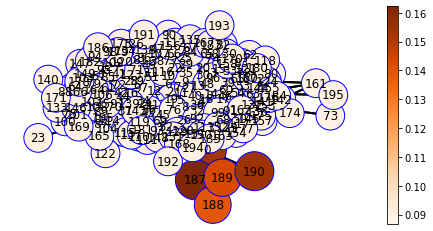

In [28]:
figsize = (8,4)
dataset.subgraph = True
kwargs = []
if figsize is not None:
    plt.figure(figsize=figsize)
G = to_networkx(dataset[idx])

pos = nx.kamada_kawai_layout(G)

node_sizes = 800 * size_ratio
node_colors = class_score[class_idx]['rel']
cmap = plt.cm.Oranges

nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=cmap,
    edgecolors='blue'
)
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="-",
    arrowsize=10,
    width=2,
)
label_list = {}
for i in range(dataset[idx].x.shape[0]):
    label_list[i] = str(i)
    if 'node_name_list' in kwargs:
        node_name_idx = int(np.argmax(dataset[idx].x[i]))
        label_list[i] += ':' + kwargs['node_name_list'][node_name_idx]

labels = nx.draw_networkx_labels(G, pos, label_list, font_size=12, font_color="black")
plt.colorbar(nodes)

ax = plt.gca()
ax.set_axis_off()
plt.show()

In [29]:
np.argsort(node_colors)[::-1]

array([187, 190,   0, 189, 188,   1,  30,  42,  15,  44, 107,  38,  54,
        13,  55,  32,  22,  84,  49,  48,  95,  65,  83,  74,  39,  61,
        70, 103, 109, 127, 170,  67, 106,  79,  41, 123, 180, 164, 183,
       178, 179, 172, 182, 159, 166, 130,  33,  98, 134, 112,  57,  71,
       149, 147,  37, 173, 167, 120, 135,  25, 117, 191,  18, 155, 110,
       128, 114,  10,   7, 176, 152,  27,  24,  63, 163, 175, 162, 168,
        86,  85,  52,  31,  46, 194,  94, 143,  20,  29,  40,  21,  89,
       116,  51,  53,  62, 124, 126, 129,  78,  47,   2,  93, 148,  36,
        60,  88, 141, 186, 153, 125, 111,  87, 101,  34,  26, 105,  59,
        50, 142,  35, 151, 193, 156, 136, 145,  68,  96, 100, 157, 185,
       184,  58,  82, 140,  69, 132, 192,  64, 118, 108, 122, 113, 171,
         6, 104, 146, 174,  80, 161, 139,   8, 119,  72, 102,  45,  66,
        99, 177,  75,  92, 160,  12, 195, 181,  19, 138, 169,   9,  17,
       137, 158,  11, 144, 133,  81, 154,  43, 115, 150,  23,  1

In [30]:
truth_node

{0, 187, 188, 189, 190}

In [76]:
preprocess_adj(sub_edge_label_matrix)

(array([[0, 1],
        [0, 3],
        [1, 0],
        [1, 4],
        [1, 2],
        [1, 5],
        [2, 4],
        [2, 1],
        [2, 3],
        [3, 0],
        [3, 2],
        [4, 1],
        [4, 2],
        [5, 1]], dtype=int32),
 array([0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.],
       dtype=float32),
 (6, 6))